### Import the necessary libraries

In [52]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras import layers, models
import requests
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### Loading the data

In [53]:
# load the data locally
df = pd.read_pickle('data/words_df_all.pkl.gz')

In [18]:
"""# Load the data in Google Colab

# first, upload the words_df_all.pkl.gz to Google Drive
# then, run the following code in Google Colab
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Read the file from Google Drive
file_path = '/content/drive/MyDrive/words_df_all.pkl.gz'
df = pd.read_pickle(file_path)"""

"# Load the data in Google Colab\n\n# first, upload the words_df_all.pkl.gz to Google Drive\n# then, run the following code in Google Colab\n# Mount Google Drive\nfrom google.colab import drive\ndrive.mount('/content/drive')\n\n# Read the file from Google Drive\nfile_path = '/content/drive/MyDrive/words_df_all.pkl.gz'\ndf = pd.read_pickle(file_path)"

In [19]:
df.head()

,WordID,SegmentationResult,GrayLevel,BoundingBox,GrammaticalTag,Transcription,ImageData
0,a01-000u-00-00,ok,154,"(408, 768, 27, 51)",AT,A,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
1,a01-000u-00-01,ok,154,"(507, 766, 213, 48)",NN,MOVE,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
2,a01-000u-00-02,ok,154,"(796, 764, 70, 50)",TO,to,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
3,a01-000u-00-03,ok,154,"(919, 757, 166, 78)",VB,stop,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
4,a01-000u-00-04,ok,154,"(1185, 754, 126, 61)",NPT,Mr.,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."


### Neural Networks

**On shapes...**

**CNNs**

- Always have to give a 4D array as input to the CNN. So input data has a shape of (batch_size, height, width, depth).

- The output of the CNN is also a 4D array. Where batch size would be the same as input batch size but the other 3 dimensions of the image might change depending upon the values of filter, kernel size, and padding we use. (batch_size, height, width, depth)

- Input data to the dense layer 2D must be an array of shape (batch_size, units). And the output of the convolution layer is a 4D array. Thus we have to change the dimension of output received from the convolution layer to a 2D array.


<img src="convnet_input.png" width="500" height="400">

**RNNs**

- Always have to give a 3D array as an input to the LSTM network. 

- The first dimension represents the batch size, the second dimension represents the time-steps and the third dimension represents the number of units in one input sequence. For example, the input shape looks like (batch_size, time_steps, units).

- The output of the LSTM could be a 2D array or 3D array depending upon the return_sequences argument.

- return_sequence argument: Tells whether to return the output at each time step instead of the final time step. 

- If return_sequence is False, the output is a 2D array. (batch_size, units)

- If return_sequence is True, the output is a 3D array. (batch_size, time_steps, units)


<img src="LSTM_input.png" width="500" height="400">


Function to plot the model Training and Validation Loss and Accuracy

In [2]:
# Function: Plotting the Training and Validation Loss and Accuracy
def plot_history(history):
    # Get training and test loss histories
    training_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1)

    # Visualize loss history
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, val_loss, 'b-')
    plt.legend(['Training Loss', 'Val Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    # Get training and test accuracy histories
    training_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Visualize accuracy history
    plt.plot(epoch_count, training_accuracy, 'r--')
    plt.plot(epoch_count, val_accuracy, 'b-')
    plt.legend(['Training Accuracy', 'Val Accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

### A: **1 character** words model

In [3]:
# randomize the order of the rows in the df
df_char = df.sample(frac=1).reset_index(drop=True)

# consider only one-character words in the df
df_char = df_char[df_char['Transcription'].apply(len) == 1]

# consider only SegmentationResluts == 'ok'
df_char = df_char[df_char['SegmentationResult'] == 'ok']

# Split data into training and validation sets
X = np.stack(df_char['ImageData'].values)  # Convert the list of images to a numpy array
y = df_char['Transcription'].values

NameError: name 'df' is not defined

In [49]:
print(len(df_char))

14172


In [50]:
# Encode the characters to integers. 

# Example: '!' -> 1, '"' -> 2, etc.
# get the vocabulary list
vocabulary = sorted(set(''.join(y)))

# create a dictionary mapping each character to the vocabulary list index. do not use 0.
char_to_num = {char: idx for idx, char in enumerate(vocabulary)}

print(char_to_num)

# subsitute the characters in y with the corresponding number. example: '!' -> 1, '"' -> 2, etc." each label value is an integer
y = [char_to_num[char] for char in y]

# y to np.array
y = np.array(y)

print(y)

{'!': 0, '"': 1, '#': 2, '&': 3, "'": 4, '(': 5, ')': 6, '*': 7, ',': 8, '-': 9, '.': 10, '1': 11, '2': 12, '3': 13, '4': 14, '5': 15, '6': 16, '7': 17, '8': 18, '9': 19, ':': 20, ';': 21, '?': 22, 'A': 23, 'B': 24, 'C': 25, 'D': 26, 'E': 27, 'F': 28, 'G': 29, 'H': 30, 'I': 31, 'J': 32, 'K': 33, 'L': 34, 'N': 35, 'O': 36, 'V': 37, 'a': 38, 'c': 39, 'x': 40}
[ 8  9 38 ... 38  8  8]


In [8]:
TRAIN_SPLIT = 0.9
VAL_SPLIT = 0.05
TEST_SPLIT = 0.05

# split the data into training, validation and test sets
X_train = X[:int(X.shape[0]*TRAIN_SPLIT)]
y_train = y[:int(y.shape[0]*TRAIN_SPLIT)]

X_val = X[int(X.shape[0]*TRAIN_SPLIT):int(X.shape[0]*(TRAIN_SPLIT+VAL_SPLIT))]
y_val = y[int(y.shape[0]*TRAIN_SPLIT):int(y.shape[0]*(TRAIN_SPLIT+VAL_SPLIT))]

X_test = X[int(X.shape[0]*(TRAIN_SPLIT+VAL_SPLIT)):]
y_test = y[int(y.shape[0]*(TRAIN_SPLIT+VAL_SPLIT)):]

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(12754, 32, 128, 1)
(12754,)
(709, 32, 128, 1)
(709,)
(709, 32, 128, 1)
(709,)


#### Baseline model

In [ ]:
def create_model(num_classes):
    model = Sequential([
        # Convolutional layer learns 32 filters using a 3x3 kernel
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 128, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        #Dropout(0.25),

        # Adding a second convolutional layer with 64 filters
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        #Dropout(0.25),

        # Flatten the 3D output to 1D and add a dense layer
        Flatten(),
        Dense(128, activation='relu'),
        #Dropout(0.5),
        Dropout(0.1),

        # Output layer with softmax activation for classification
        Dense(num_classes, activation='softmax')
    ])
    # adam with a learning rate of 0.001

    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

num_classes = len(char_to_num)
model = create_model(num_classes)

# Save the best model during the training
best_model_path = 'best_model_char.h5'  
model_checkpoint = ModelCheckpoint(best_model_path, 
                                   monitor='val_loss', 
                                   save_best_only=True, 
                                   verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # You can set this to a higher number.
    batch_size=128,
    callbacks=[early_stopping, model_checkpoint]
)

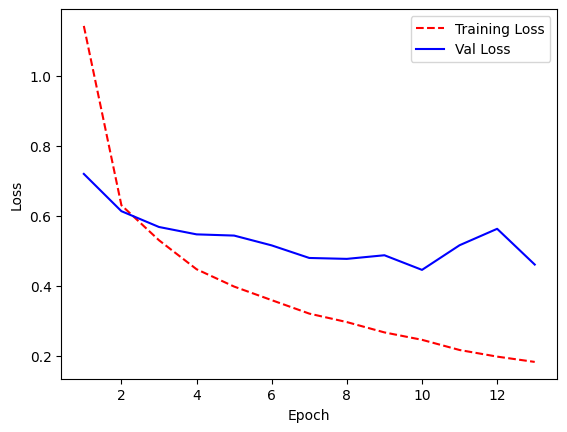

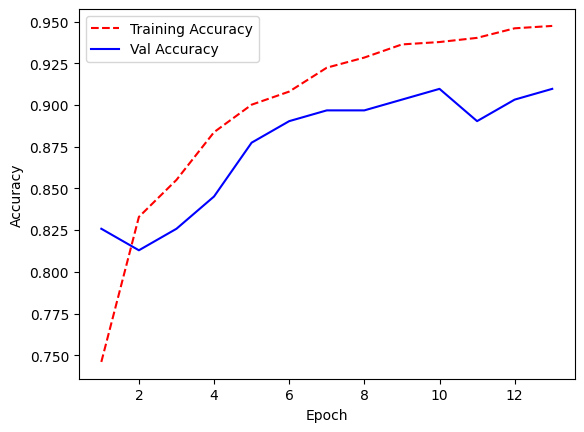

In [69]:
plot_history(history)

#### Hyper Parameter Tuning

In [14]:
import keras_tuner as kt

Model Building Function to be used under Keras Tuner.




In [ ]:
def model_builder_hyper_1char(hp):
    seq_to_seq_model = Sequential()

    seq_to_seq_model.add(Conv2D(hp.Int('Input CNN units', min_value=64, max_value=256, step=32), kernel_size=(3, 3), input_shape=(32, 128, 1), activation="relu", padding="SAME"))
    seq_to_seq_model.add(MaxPooling2D(pool_size=(2, 2)))
    for i in range(hp.Int("layers", 1 , 5)):
        seq_to_seq_model.add(Conv2D(hp.Int('CNN units ' + str(i), min_value=64, max_value=256, step=32), kernel_size=(3, 3), activation="relu", padding="SAME"))
        seq_to_seq_model.add(MaxPooling2D(pool_size=(2, 2)))
    seq_to_seq_model.add(Flatten())
    seq_to_seq_model.add(Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu'))
    seq_to_seq_model.add(Dropout(0.1))
    seq_to_seq_model.add(Dense(num_classes, activation="softmax"))

    seq_to_seq_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return seq_to_seq_model

Tuner using a max of 20 trials (combinations). Using Val accuracy as objective.

In [ ]:
num_classes = len(char_to_num)

tuner_1char = kt.RandomSearch(
    model_builder_hyper_1char,
    objective='val_accuracy',
    max_trials=20,  #Number of experiments
    directory='my_dir_hyper_1char',
    project_name='seq_to_seq_model_1char',
    seed=24
)
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

tuner_1char.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])

Trial 20 Complete [00h 00m 18s]
val_accuracy: 0.8899859189987183

Best val_accuracy So Far: 0.9153737425804138
Total elapsed time: 00h 06m 15s


Trials Summary Results


In [ ]:
tuner_1char.results_summary()

Results summary
Results in my_dir_hyper_1char/seq_to_seq_model_1char
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 01 summary
Hyperparameters:
Input CNN units: 64
layers: 3
CNN units 0: 160
dense_units: 64
CNN units 1: 64
CNN units 2: 64
Score: 0.9153737425804138

Trial 10 summary
Hyperparameters:
Input CNN units: 64
layers: 3
CNN units 0: 256
dense_units: 192
CNN units 1: 224
CNN units 2: 128
CNN units 3: 96
CNN units 4: 128
Score: 0.9139633178710938

Trial 08 summary
Hyperparameters:
Input CNN units: 160
layers: 2
CNN units 0: 224
dense_units: 256
CNN units 1: 96
CNN units 2: 96
CNN units 3: 160
CNN units 4: 96
Score: 0.9083215594291687

Trial 09 summary
Hyperparameters:
Input CNN units: 160
layers: 4
CNN units 0: 96
dense_units: 256
CNN units 1: 96
CNN units 2: 128
CNN units 3: 64
CNN units 4: 96
Score: 0.9083215594291687

Trial 07 summary
Hyperparameters:
Input CNN units: 64
layers: 4
CNN units 0: 192
dense_units: 256
CNN units 1: 128
CNN units 2: 64

New Model with the best Hyper-Parameters

In [ ]:
best_hps_1char = tuner_1char.get_best_hyperparameters(num_trials=10)[0]
seq_to_seq_model_1char = tuner_1char.hypermodel.build(best_hps_1char)

seq_to_seq_model_1char.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 128, 64)       640       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 64, 160)       92320     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 8, 32, 160)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 32, 64)         92224     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 4, 16, 64)        

In [ ]:
print("Best hyperparameters:", best_hps_1char.values)

Best hyperparameters: {'Input CNN units': 64, 'layers': 3, 'CNN units 0': 160, 'dense_units': 64, 'CNN units 1': 64, 'CNN units 2': 64}


In [5]:
# Save the best model during the training
best_hyper_model_path = 'best_hyper_model_1char.h5'  # Specify the path where you want to save the best model
model_checkpoint = ModelCheckpoint(best_hyper_model_path,
                                   monitor='val_loss',
                                   save_best_only=True,
                                   verbose=1)


In [ ]:
# Fitting the new hyper tuned model to training data
history_2 = seq_to_seq_model_1char.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),  # replace with your validation data
    epochs=50,  # Set a high number because early stopping will halt the training
    batch_size=64,  # Adjust based on your data and computing resources
    callbacks=[early_stopping, model_checkpoint]  # Add the model checkpoint callback here
)


Epoch 1/50
192/200 [===========================>..] - ETA: 0s - loss: 1.3508 - accuracy: 0.6565
Epoch 1: val_loss improved from inf to 0.87029, saving model to best_hyper_model_1char.h5
200/200 [==============================] - 4s 7ms/step - loss: 1.3345 - accuracy: 0.6601 - val_loss: 0.8703 - val_accuracy: 0.7616
Epoch 2/50
 19/200 [=>............................] - ETA: 1s - loss: 0.8551 - accuracy: 0.7640

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


195/200 [============================>.] - ETA: 0s - loss: 0.7394 - accuracy: 0.7883
Epoch 2: val_loss improved from 0.87029 to 0.64041, saving model to best_hyper_model_1char.h5
200/200 [==============================] - 1s 6ms/step - loss: 0.7396 - accuracy: 0.7884 - val_loss: 0.6404 - val_accuracy: 0.8322
Epoch 3/50
198/200 [============================>.] - ETA: 0s - loss: 0.5808 - accuracy: 0.8317
Epoch 3: val_loss improved from 0.64041 to 0.54137, saving model to best_hyper_model_1char.h5
200/200 [==============================] - 1s 6ms/step - loss: 0.5805 - accuracy: 0.8319 - val_loss: 0.5414 - val_accuracy: 0.8491
Epoch 4/50
191/200 [===========================>..] - ETA: 0s - loss: 0.4986 - accuracy: 0.8545
Epoch 4: val_loss improved from 0.54137 to 0.43388, saving model to best_hyper_model_1char.h5
200/200 [==============================] - 1s 6ms/step - loss: 0.4970 - accuracy: 0.8546 - val_loss: 0.4339 - val_accuracy: 0.8745
Epoch 5/50
199/200 [============================

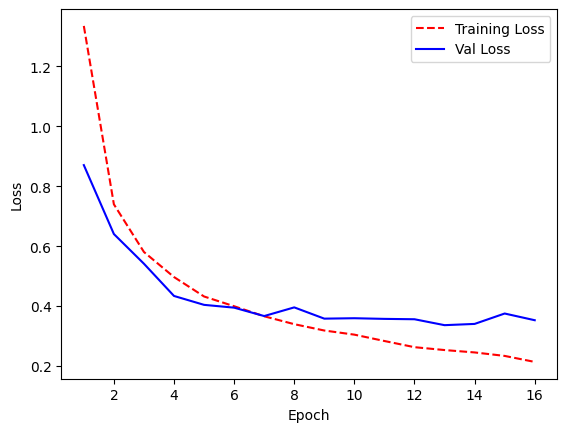

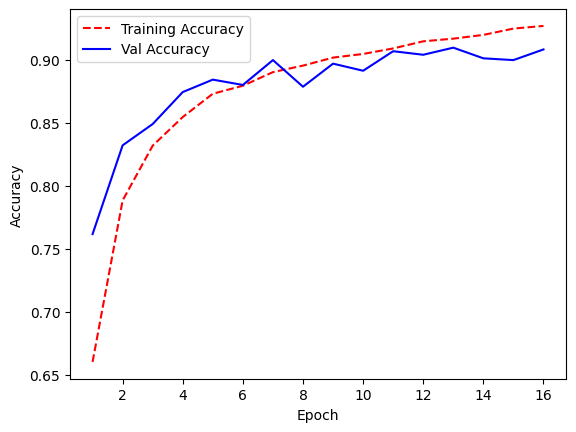

In [ ]:
plot_history(history_2)

#### Test

In [9]:
import pandas as pd

# Create a reverse mapping from number to character
num_to_char = {num: char for char, num in char_to_num.items()}

# Uncoment the lines below to run test data vs the hypertuned model.
from keras.models import load_model
model = load_model('best_hyper_model_1char.h5')


# Uncoment the lines below to run test data vs the baseline model.
"""
from keras.models import load_model
model = load_model('best_model_char.h5')
"""

# Make predictions on the test data
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Decode the predictions into actual characters
predicted_transcriptions = [num_to_char.get(num, '') for num in predicted_classes]
real_transcriptions = [num_to_char.get(num, '') for num in y_test]

# Determine if the prediction is correct (1) or not (0)
correct_predictions = [1 if real == pred else 0 for real, pred in zip(real_transcriptions, predicted_transcriptions)]

# Get the indices for the test set
test_indices = range(int(len(df_char) * (TRAIN_SPLIT + VAL_SPLIT)), len(df_char))

# Ensure that the lengths of your test labels and indices match
assert len(test_indices) == len(y_test), "Mismatch in test set size and actual labels"

# Extract WordIDs and ImgageData for the test set using the correct indices
test_word_ids = df.iloc[test_indices]['WordID'].values
test_img_data = df.iloc[test_indices]['ImageData'].values

# Ensure that every list you're going to put into the DataFrame is of the same length
assert len(test_word_ids) == len(test_img_data) == len(predicted_transcriptions) == len(real_transcriptions), "Mismatch in the length of data columns"

# Create the DataFrame
results_df = pd.DataFrame({
    'WordID': test_word_ids,
    'Real': real_transcriptions,
    'Predicted': predicted_transcriptions,
    'Correct': correct_predictions,
    'ImageData': test_img_data
})

# Display the first few rows of the DataFrame
results_df.head()

23/23 [==============================] - 1s 38ms/step


,WordID,Real,Predicted,Correct,ImageData
0,a06-075-06-05,.,.,1,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
1,a06-075-06-06,",",",",1,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
2,a06-075-06-07,a,a,1,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
3,a06-075-07-00,",",",",1,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
4,a06-075-07-01,.,.,1,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."


In [10]:
print(model.evaluate(X_test, y_test))

23/23 [==============================] - 1s 37ms/step - loss: 0.2274 - accuracy: 0.9295
[0.22738634049892426, 0.929478108882904]


In [11]:
print(results_df['Correct'].value_counts())
print(results_df['Correct'].value_counts() / len(results_df))

Correct
1    659
0     50
Name: count, dtype: int64
Correct
1    0.929478
0    0.070522
Name: count, dtype: float64


In [12]:
incorrect = results_df[results_df['Correct'] == 0]
incorrect.head()

,WordID,Real,Predicted,Correct,ImageData
26,a06-090-01-00,',",",0,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
27,a06-090-01-01,',",",0,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
30,a06-090-01-04,',",",0,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
45,a06-090-03-01,',",",0,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
49,a06-090-03-05,',",",0,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."


In [13]:
# print evaluation metrics
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.98      0.96      0.97        47
           2       0.67      1.00      0.80         2
           3       1.00      0.50      0.67         4
           4       0.85      0.31      0.45        36
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         5
           8       0.87      0.98      0.92       217
           9       0.94      0.94      0.94        18
          10       0.98      0.98      0.98       206
          11       1.00      0.67      0.80         3
          12       0.67      1.00      0.80         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         1
          20       1.00      1.00      1.00        13
          21       1.00      1.00      1.00         9
          22       0.86      1.00      0.92         6
          23       0.90    

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### B: **1 or more characters** words model

In [5]:
# load the data
df = pd.read_pickle('data/words_df_all.pkl.gz')

# consider only SegmentationResluts == 'ok'
df = df[df['SegmentationResult'] == 'ok']

for i, img in enumerate(df['ImageData']):
    if type(img) != np.ndarray:
        print(df['WordID'][i])
        # delete the current row from df
        df.drop(i, inplace=True)

# print the row in which imagdate is none
df[df['ImageData'].isnull()]

df = df[df['ImageData'].notnull()]

vocabulary = sorted(set(''.join(df['Transcription'].values)))

# shuffle
df = df.sample(frac=1).reset_index(drop=True)

# consider only words that do not contain spaces or pontuation
punctuation = [' ', '.', ',', '!', '?', "'", '"', '(', ')', '[', ']', '{', '}', '/', '\\', '|', '*', '+', '=', '_', '#', '@', '%', '&', '^', '~', '`', '<', '>', ':', ';']
df = df[df['Transcription'].apply(lambda x: all(char not in x for char in punctuation))]

# Split data into training and validation sets
X = np.stack(df['ImageData'].values)  # Convert the list of images to a numpy array
y = np.array(df['Transcription'].values)

def encode_to_labels(y):
    global vocabulary, char_to_num
    # create a list of the chartcaters vocabulary ordered alphabetically
    vocabulary = sorted(set(''.join(y)))

    # create a dictionary mapping each character to the vocabulary list index. do not use 0.
    char_to_num = {char:idx+1 for idx, char in enumerate(vocabulary)}

    # transform y values to numerical using the char_to_num dictionary, using 0 for padding. the length of each word is the maximum length of the words in the dataset
    y_encoded = []
    for word in y:
        word_encoded = [char_to_num[char] for char in word]
        y_encoded.append(word_encoded)

    # pad the encoded values (fill with 0s to the right)
    y_encoded = tf.keras.preprocessing.sequence.pad_sequences(y_encoded, padding='post')

    # normalize the values
    # y_encoded = y_encoded / np.array(len(vocabulary))

    return y_encoded

y = encode_to_labels(y)

a01-096u-04-02
m03-062-07-02


In [6]:
print(y.shape)

(83831, 21)


In [7]:
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1

# split the data into training, validation and test sets
X_train = X[:int(X.shape[0]*TRAIN_SPLIT)]
y_train = y[:int(y.shape[0]*TRAIN_SPLIT)]

X_val = X[int(X.shape[0]*TRAIN_SPLIT):int(X.shape[0]*(TRAIN_SPLIT+VAL_SPLIT))]
y_val = y[int(y.shape[0]*TRAIN_SPLIT):int(y.shape[0]*(TRAIN_SPLIT+VAL_SPLIT))]

X_test = X[int(X.shape[0]*(TRAIN_SPLIT+VAL_SPLIT)):]
y_test = y[int(y.shape[0]*(TRAIN_SPLIT+VAL_SPLIT)):]

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(67064, 32, 128, 1)
(67064, 21)
(8383, 32, 128, 1)
(8383, 21)
(8384, 32, 128, 1)
(8384, 21)


In [8]:
# one hot encode y
y_train = to_categorical(y_train, num_classes=len(vocabulary)+1)
y_val = to_categorical(y_val, num_classes=len(vocabulary)+1)
y_test = to_categorical(y_test, num_classes=len(vocabulary)+1)

print(y_train.shape)

(67064, 21, 64)


#### CNN

##### Baseline Model

In [27]:
# save y_train[0] to txt file
np.savetxt('data/y_train_0.txt', y_train[2], fmt='%d')

In [31]:
# ---- DESCRIPTION OF THE INPUT DATA ----
# X_train shape: (num_samples, 32, 128, 1)
# y_train shape: (num_samples, max(len(words)),len(vocabulary))
# example of a X_train value: matrix of 32x128 with values between 0 and 1
# example of a y_train value: matrix of 17x63 with values between 0 and 1. first column is the padding, the rest are the one-hot encoded values of the transcription

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers import Reshape

def create_cnn_model(input_shape, num_classes, sequence_length):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        Flatten(),
        
        Dense(256, activation='relu'),
        Dropout(0.1),
        
        Dense(sequence_length * num_classes, activation='softmax'),
        Reshape((sequence_length, num_classes))


    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

create_cnn_model(input_shape=(32, 128, 1), num_classes=len(vocabulary)+1, sequence_length=y_train.shape[1]).summary()


from keras.callbacks import EarlyStopping

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Stop training when there is no improvement in the validation loss for 3 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Save the best model during the training
best_model_path = 'best_model_word.h5'  
model_checkpoint = ModelCheckpoint(best_model_path, 
                                   monitor='val_loss', 
                                   save_best_only=True, 
                                   verbose=1)

# Assume create_cnn_model is a function you've defined to create your model
model = create_cnn_model(input_shape=(32, 128, 1), num_classes=len(vocabulary)+1, sequence_length=y_train.shape[1])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # Set a high number because early stopping will halt the training
    batch_size=128,
    callbacks=[early_stopping, model_checkpoint]  # Add the model checkpoint callback here
)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 30, 126, 32)       320       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 15, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 13, 61, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 6, 30, 64)         0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 4, 28, 128)        73856     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 2, 14, 128)       

Epoch 1/50
524/524 [==============================] - ETA: 0s - loss: 0.7950 - accuracy: 0.7948
Epoch 1: val_loss improved from inf to 0.67016, saving model to best_model_word.h5
524/524 [==============================] - 57s 108ms/step - loss: 0.7950 - accuracy: 0.7948 - val_loss: 0.6702 - val_accuracy: 0.8106
Epoch 2/50


/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


524/524 [==============================] - ETA: 0s - loss: 0.6564 - accuracy: 0.8164
Epoch 2: val_loss improved from 0.67016 to 0.61911, saving model to best_model_word.h5
524/524 [==============================] - 60s 114ms/step - loss: 0.6564 - accuracy: 0.8164 - val_loss: 0.6191 - val_accuracy: 0.8224
Epoch 3/50
524/524 [==============================] - ETA: 0s - loss: 0.6146 - accuracy: 0.8251
Epoch 3: val_loss improved from 0.61911 to 0.58120, saving model to best_model_word.h5
524/524 [==============================] - 60s 114ms/step - loss: 0.6146 - accuracy: 0.8251 - val_loss: 0.5812 - val_accuracy: 0.8303
Epoch 4/50
524/524 [==============================] - ETA: 0s - loss: 0.5832 - accuracy: 0.8314
Epoch 4: val_loss improved from 0.58120 to 0.55343, saving model to best_model_word.h5
524/524 [==============================] - 59s 112ms/step - loss: 0.5832 - accuracy: 0.8314 - val_loss: 0.5534 - val_accuracy: 0.8381
Epoch 5/50
524/524 [==============================] - ETA: 0

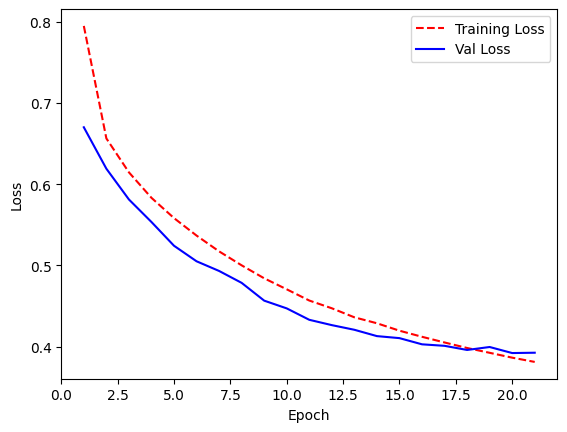

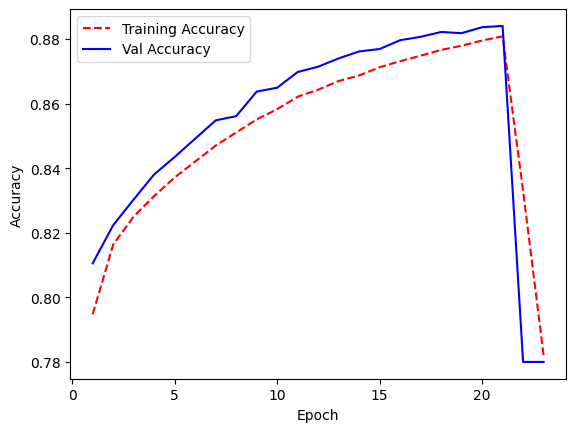

In [32]:
plot_history(history)

##### Hyper Parameter Tuning

In [ ]:
import keras_tuner as kt

Model Building Functio to be used under Keras TUuer.

- Testing 1 Input CNN Layer. Neurous between 32 and 128 with a step of 32.
- Testing between 2 and 4 CNN layers. Neurous between 32 and 128 with a step of 32.
- Testing 1 DEnse layer. Neurous between 32 and 128 with a step of 32.
- Testing different dropout rates betqeen 0 and 0,5 with a step of 0,1.
- Testing 3 different learning rates [1e-1, 1e-2, 1e-3, 1e-4]



In [ ]:
def model_builder(hp):
    seq_to_seq_model = Sequential()

    seq_to_seq_model.add(Conv2D(hp.Int('Input CNN units', min_value=64, max_value=256, step=64), kernel_size=(3, 3), input_shape=(32, 128, 1), activation="relu", padding="SAME"))
    seq_to_seq_model.add(MaxPooling2D(pool_size=(2, 2)))
    for i in range(hp.Int("layers", 2 , 4)):
        seq_to_seq_model.add(Conv2D(hp.Int('CNN units ' + str(i), min_value=64, max_value=256, step=64), kernel_size=(3, 3), activation="relu", padding="SAME"))
        seq_to_seq_model.add(MaxPooling2D(pool_size=(2, 2)))
    seq_to_seq_model.add(Flatten())
    seq_to_seq_model.add(Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu'))
    seq_to_seq_model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.5)))
    seq_to_seq_model.add(Dense((y_train.shape[1] * (len(vocabulary)+1)), activation="softmax"))
    seq_to_seq_model.add(Reshape((y_train.shape[1],len(vocabulary)+1)))

    seq_to_seq_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return seq_to_seq_model

Tuner using a max of 20 trials (combinations). Using Val accuracy as objective.

In [ ]:
tuner = kt.RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=20,  #Number of experiments
    directory='my_dir',
    project_name='seq_to_seq_model',
    seed=24
)
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

tuner.search(X_train, y_train,
             epochs=50,
             validation_data=(X_val, y_val),
             batch_size=128,
             callbacks=[early_stopping])

Trial 20 Complete [00h 01m 28s]
val_accuracy: 0.889653742313385

Best val_accuracy So Far: 0.9091353416442871
Total elapsed time: 00h 35m 39s


Trials Summary Results


In [ ]:
tuner.results_summary()

Results summary
Results in my_dir/seq_to_seq_model
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 14 summary
Hyperparameters:
Input CNN units: 64
layers: 4
CNN units 0: 32
CNN units 1: 96
dense_units: 128
dropout: 0.0
learning rate: 0.0001
CNN units 2: 96
CNN units 3: 256
Score: 0.9091353416442871

Trial 17 summary
Hyperparameters:
Input CNN units: 128
layers: 3
CNN units 0: 64
CNN units 1: 128
dense_units: 128
dropout: 0.0
learning rate: 0.0001
CNN units 2: 128
CNN units 3: 256
Score: 0.9075449705123901

Trial 15 summary
Hyperparameters:
Input CNN units: 128
layers: 2
CNN units 0: 96
CNN units 1: 64
dense_units: 192
dropout: 0.30000000000000004
learning rate: 0.01
CNN units 2: 32
CNN units 3: 192
Score: 0.8950722217559814

Trial 04 summary
Hyperparameters:
Input CNN units: 32
layers: 4
CNN units 0: 32
CNN units 1: 96
dense_units: 64
dropout: 0.1
learning rate: 0.01
CNN units 2: 128
CNN units 3: 64
Score: 0.8931297659873962

Trial 18 summary
Hyperparamete

New Model with the best Hyper-Parametera

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=2)[0]
seq_to_seq_model2 = tuner.hypermodel.build(best_hps)

seq_to_seq_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 128, 64)       640       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 64, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 8, 32, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 32, 96)         27744     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 4, 16, 96)        

In [ ]:
print("Best hyperparameters:", best_hps.values)

Best hyperparameters: {'Input CNN units': 64, 'layers': 4, 'CNN units 0': 32, 'CNN units 1': 96, 'dense_units': 128, 'dropout': 0.0, 'learning rate': 0.0001, 'CNN units 2': 96, 'CNN units 3': 256}


In [28]:

# Save the best model during the training
best_hyper_model_path = 'best_hyper_model_word_cnn1.h5'  # Specify the path where you want to save the best model
model_checkpoint = ModelCheckpoint(best_hyper_model_path,
                                   monitor='val_loss',
                                   save_best_only=True,
                                   verbose=1)


In [ ]:
seq_to_seq_model2 = load_model('best_hyper_model_word_cnn.h5')


history_2 = seq_to_seq_model2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),  # replace with your validation data
    epochs=100,  # Set a high number because early stopping will halt the training
    batch_size=128,  # Adjust based on your data and computing resources
    callbacks=[early_stopping, model_checkpoint]  # Add the model checkpoint callback here
)


Epoch 1/100
584/590 [============================>.] - ETA: 0s - loss: 0.7553 - accuracy: 0.8000
Epoch 1: val_loss improved from inf to 0.64302, saving model to best_hyper_model_word_cnn.h5
590/590 [==============================] - 7s 8ms/step - loss: 0.7545 - accuracy: 0.8000 - val_loss: 0.6430 - val_accuracy: 0.8191
Epoch 2/100
 17/590 [..............................] - ETA: 3s - loss: 0.6323 - accuracy: 0.8207

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


583/590 [============================>.] - ETA: 0s - loss: 0.5924 - accuracy: 0.8293
Epoch 2: val_loss improved from 0.64302 to 0.55423, saving model to best_hyper_model_word_cnn.h5
590/590 [==============================] - 4s 7ms/step - loss: 0.5922 - accuracy: 0.8294 - val_loss: 0.5542 - val_accuracy: 0.8393
Epoch 3/100
587/590 [============================>.] - ETA: 0s - loss: 0.5136 - accuracy: 0.8471
Epoch 3: val_loss improved from 0.55423 to 0.49470, saving model to best_hyper_model_word_cnn.h5
590/590 [==============================] - 4s 7ms/step - loss: 0.5133 - accuracy: 0.8472 - val_loss: 0.4947 - val_accuracy: 0.8536
Epoch 4/100
586/590 [============================>.] - ETA: 0s - loss: 0.4607 - accuracy: 0.8606
Epoch 4: val_loss improved from 0.49470 to 0.45196, saving model to best_hyper_model_word_cnn.h5
590/590 [==============================] - 4s 7ms/step - loss: 0.4606 - accuracy: 0.8607 - val_loss: 0.4520 - val_accuracy: 0.8649
Epoch 5/100
589/590 [================

##### Final Hyper model - Word CNN

#### Test

In [62]:
import numpy as np


# now that the model is trained, let's make predictions on the test set
# first, load the model best_model.h5
from keras.models import load_model
model = load_model('best_hyper_model_word_hyper_CRNN.h5') # Hyoertuned model

# make predictions on the test set
predictions = model.predict(X_test)

def decode_predictions(predictions):
    predicted_words = []
    
    for prediction in predictions:
        # Convert prediction probabilities to character indices
        char_indices = np.argmax(prediction, axis=-1)
        
        # Decode indices to characters
        decoded_chars = [num_to_char.get(idx, '') for idx in char_indices]
        
        # Convert sequence of characters to a single word
        decoded_word = ''.join(decoded_chars).rstrip(num_to_char.get(0, ''))
        
        # Append the decoded word to the list
        predicted_words.append(decoded_word)
    
    return predicted_words

num_to_char = {idx: char for char, idx in char_to_num.items()}

predicted_words = decode_predictions(predictions)

262/262 [==============================] - 12s 46ms/step


In [63]:
import pandas as pd

def decode_y(y):
    # Decoding the one-hot encoded y_test to characters
    decoded_words = []
    for sample in y:
        char_indices = np.argmax(sample, axis=-1)
        decoded_chars = [num_to_char.get(idx, '') for idx in char_indices]
        decoded_word = ''.join(decoded_chars).rstrip(num_to_char.get(0, ''))
        decoded_words.append(decoded_word)
    return decoded_words

# Get the indices for the test set
test_indices = range(int(len(df) * (TRAIN_SPLIT + VAL_SPLIT)), len(df))

# Ensure that the lengths of your test labels and indices match
assert len(test_indices) == len(y_test), "Mismatch in test set size and actual labels"

# Extract WordIDs and ImgageData for the test set using the correct indices
test_word_ids = df.iloc[test_indices]['WordID'].values
test_img_data = df.iloc[test_indices]['ImageData'].values


# Assuming y_test is already one-hot encoded and you have a num_to_char dictionary
real_words = decode_y(y_test)

# Assuming you have a 'WordID' column in your initial dataframe (df)
results = pd.DataFrame({
    'WordID': test_word_ids,
    'real': real_words,
    'predicted': predicted_words,
    'ImageData': test_img_data 
})

# Calculate the 'correct' column (1 if the predicted word matches the real word, 0 otherwise)
results['correct'] = (results['predicted'] == results['real']).astype(int)

In [64]:
model.evaluate(X_test, y_test)

262/262 [==============================] - 13s 49ms/step - loss: 0.2725 - accuracy: 0.9164


[0.27254801988601685, 0.9163656234741211]

In [66]:
from torchmetrics.text import CharErrorRate
from torchmetrics.text import WordErrorRate
# Initialize the metric
cer = CharErrorRate()

# Compute the metric
cer.update(predicted_words, real_words)
print(cer.compute())

# Initialize the metric
wer = WordErrorRate()

# Compute the metric
wer.update(predicted_words, real_words)
print(wer.compute())

tensor(0.3575)
tensor(0.5044)


In [19]:
results.head(20)

,WordID,real,predicted,ImageData,correct
0,c04-128-03-08,eight-round,engtttemhed,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",0
1,m02-102-08-07,contracts,cantaatl,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",0
2,l04-141-02-06,and,and,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",1
3,e04-026-00-05,to,to,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",1
4,a01-030-03-03,had,had,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",1
5,c06-000-02-09,the,the,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",1
6,h07-017-01-02,some,some,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",1
7,m02-106-08-08,young,young,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",1
8,a03-071-07-03,Die,Di,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",0
9,e02-117-03-04,on,on,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",1


In [20]:
# calculate a metric that considers the number of correct characters in the predicted word and add the column of the metric to the results df
def calculate_metric(row):
    correct_chars = 0
    for pred_char, real_char in zip(row['predicted'], row['real']):
        if pred_char == real_char:
            correct_chars += 1
    return correct_chars

def count_chars(row):
    return len(row['real'])

results['char_correct'] = results.apply(calculate_metric, axis=1)

# total chars
results['total_chars'] = results.apply(count_chars, axis=1)

# accuracy
results['char_accuracy'] = results['char_correct'] / results['total_chars']

In [21]:
results.head(20)

,WordID,real,predicted,ImageData,correct,char_correct,total_chars,char_accuracy
0,c04-128-03-08,eight-round,engtttemhed,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",0,4,11,0.363636
1,m02-102-08-07,contracts,cantaatl,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",0,4,9,0.444444
2,l04-141-02-06,and,and,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",1,3,3,1.000000
3,e04-026-00-05,to,to,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",1,2,2,1.000000
4,a01-030-03-03,had,had,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",1,3,3,1.000000
5,c06-000-02-09,the,the,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",1,3,3,1.000000
6,h07-017-01-02,some,some,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",1,4,4,1.000000
7,m02-106-08-08,young,young,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",1,5,5,1.000000
8,a03-071-07-03,Die,Di,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",0,2,3,0.666667
9,e02-117-03-04,on,on,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",1,2,2,1.000000


In [22]:
sum(results['char_correct']) / sum(results['total_chars'])*100

71.88275555787769

In [23]:
# average total_chars
print(results['char_accuracy'].mean())

0.7999446604736443


In [24]:
df[df['WordID'] == 'p02-022-05-06']

,WordID,SegmentationResult,GrayLevel,BoundingBox,GrammaticalTag,Transcription,ImageData


In [25]:
print(results['correct'].value_counts()/len(results))

correct
1    0.531489
0    0.468511
Name: count, dtype: float64


#### CRNN

##### Baseline model

In [54]:
# load the data
df = pd.read_pickle('data/words_df_all.pkl.gz')

# consider only SegmentationResluts == 'ok'
df = df[df['SegmentationResult'] == 'ok']

for i, img in enumerate(df['ImageData']):
    if type(img) != np.ndarray:
        print(df['WordID'][i])
        # delete the current row from df
        df.drop(i, inplace=True)

# print the row in which imagdate is none
df[df['ImageData'].isnull()]

df = df[df['ImageData'].notnull()]

vocabulary = sorted(set(''.join(df['Transcription'].values)))

# shuffle
df = df.sample(frac=1).reset_index(drop=True)

# consider only words that do not contain spaces or pontuation
punctuation = [' ', '.', ',', '!', '?', "'", '"', '(', ')', '[', ']', '{', '}', '/', '\\', '|', '*', '+', '=', '_', '#', '@', '%', '&', '^', '~', '`', '<', '>', ':', ';']
df = df[df['Transcription'].apply(lambda x: all(char not in x for char in punctuation))]

# Split data into training and validation sets
X = np.stack(df['ImageData'].values)  # Convert the list of images to a numpy array
y = np.array(df['Transcription'].values)

def encode_to_labels(y):
    global vocabulary, char_to_num
    # create a list of the chartcaters vocabulary ordered alphabetically
    vocabulary = sorted(set(''.join(y)))

    # create a dictionary mapping each character to the vocabulary list index. do not use 0.
    char_to_num = {char:idx+1 for idx, char in enumerate(vocabulary)}

    # transform y values to numerical using the char_to_num dictionary, using 0 for padding. the length of each word is the maximum length of the words in the dataset
    y_encoded = []
    for word in y:
        word_encoded = [char_to_num[char] for char in word]
        y_encoded.append(word_encoded)

    # pad the encoded values (fill with 0s to the right)
    y_encoded = tf.keras.preprocessing.sequence.pad_sequences(y_encoded, padding='post')

    # normalize the values
    # y_encoded = y_encoded / np.array(len(vocabulary))

    return y_encoded

y = encode_to_labels(y)

a01-096u-04-02
m03-062-07-02


In [55]:
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1

# split the data into training, validation and test sets
X_train = X[:int(X.shape[0]*TRAIN_SPLIT)]
y_train = y[:int(y.shape[0]*TRAIN_SPLIT)]

X_val = X[int(X.shape[0]*TRAIN_SPLIT):int(X.shape[0]*(TRAIN_SPLIT+VAL_SPLIT))]
y_val = y[int(y.shape[0]*TRAIN_SPLIT):int(y.shape[0]*(TRAIN_SPLIT+VAL_SPLIT))]

X_test = X[int(X.shape[0]*(TRAIN_SPLIT+VAL_SPLIT)):]
y_test = y[int(y.shape[0]*(TRAIN_SPLIT+VAL_SPLIT)):]

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(67064, 32, 128, 1)
(67064, 21)
(8383, 32, 128, 1)
(8383, 21)
(8384, 32, 128, 1)
(8384, 21)


In [56]:
# one hot encode y
y_train = to_categorical(y_train, num_classes=len(vocabulary)+1)
y_val = to_categorical(y_val, num_classes=len(vocabulary)+1)
y_test = to_categorical(y_test, num_classes=len(vocabulary)+1)

print(y_train.shape)

(67064, 21, 64)


In [35]:
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, Reshape, LSTM

In [36]:
def create_cnn_rnn_model(input_shape, num_classes, sequence_length):
    # Define the input layer
    inputs = Input(shape=input_shape)

    # First CNN layer with 96 units
    x = Conv2D(96, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Second CNN layer with 96 units
    x = Conv2D(96, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Third CNN layer with 96 units
    x = Conv2D(96, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(1, 2))(x)

    # Flatten the output of the CNN layers
    x = tf.keras.layers.Flatten()(x)

    # Dense layer with sequence_length * num_classes units
    x = Dense(sequence_length * num_classes, activation='relu')(x)
    x = Dropout(0.1)(x)

    # Reshape the output for the RNN layers
    x = Reshape((sequence_length, num_classes))(x)

    # First RNN (LSTM) layer, 128 units, returns sequences for the next LSTM layer
    x = LSTM(128, return_sequences=True)(x)

    # Second RNN (LSTM) layer, 128 units, this time we do not return sequences
    x = LSTM(128)(x)

    # Final Dense layer
    x = Dense(sequence_length * num_classes, activation='softmax')(x)

    # Reshape the output to match the target shape
    outputs = Reshape((sequence_length, num_classes))(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model with Adam optimizer and a learning rate of 0.001
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
# Stop training when there is no improvement in the validation loss for 3 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Save the best model during the training
best_model_path = 'test2.h5'
model_checkpoint = ModelCheckpoint(best_model_path,
                                   monitor='val_loss',
                                   save_best_only=True,
                                   verbose=1)

# Assume create_cnn_model is a function you've defined to create your model
model_test = create_cnn_rnn_model(input_shape=(32, 128, 1), num_classes=len(vocabulary)+1, sequence_length=y_train.shape[1])

"""history = model_test.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # Set a high number because early stopping will halt the training
    batch_size=128,
    callbacks=[early_stopping, model_checkpoint]  # Add the model checkpoint callback here
)"""


batch_size = 128

# Continue with your existing code for model fitting
history_crnn = model_test.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=batch_size,
    callbacks=[early_stopping, model_checkpoint]
)

In [ ]:
plot_history(history_crnn)

## Hyper Parameter Tuning - 1 or more Character Words CRNN

In [ ]:
import keras_tuner as kt

Model Building Function to be used under Keras Tuner.




In [ ]:
def model_builder_hyper_1wordCRNN(hp):
    seq_to_seq_model = Sequential()
    
    #inputs = Input(shape=(32, 128, 1))

    seq_to_seq_model.add(Input(shape=(32, 128, 1)))
    for i in range(hp.Int("CNN layers", 3 , 5)):
        seq_to_seq_model.add(Conv2D(hp.Int('CNN units ' + str(i), min_value=64, max_value=128, step=32), kernel_size=(3, 3), activation="relu", padding="SAME"))
        seq_to_seq_model.add(MaxPooling2D(pool_size=(2, 2)))
    seq_to_seq_model.add(Flatten())
    seq_to_seq_model.add(Dense(64*21, activation="relu"))
    seq_to_seq_model.add(Dropout(0.1))
    seq_to_seq_model.add(Reshape((21,64)))
    seq_to_seq_model.add(LSTM(hp.Int('LSTM units ' + str(0), min_value=64, max_value=128, step=32), return_sequences=True))
    for i in range(hp.Int("LSTM layers", 1 , 3)):
        seq_to_seq_model.add(LSTM(hp.Int('LSTM units ' + str(i+1), min_value=64, max_value=128, step=32), activation="relu"))
    seq_to_seq_model.add(Dense(21*64, activation="softmax"))
    seq_to_seq_model.add(Reshape((21,64)))

    #outputs = Reshape(21,64)
    #model = Model(inputs=inputs, outputs=outputs)

    seq_to_seq_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return seq_to_seq_model

Tuner using a max of 10 trials (combinations). Using Val accuracy as objective.

In [ ]:
tuner_1CRNN = kt.RandomSearch(
    model_builder_hyper_1wordCRNN,
    objective='val_accuracy',
    max_trials=10,  #Number of experiments
    directory='my_dir_hyper_CRNN',
    project_name='seq_to_seq_model_CRNN',
    seed=24
)
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

tuner_1CRNN.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping], batch_size=128)

Trials Summary Results


In [ ]:
tuner_1CRNN.results_summary()

New Model with the best Hyper-Parameters

In [ ]:
best_hps_CRNN = tuner_1CRNN.get_best_hyperparameters(num_trials=10)[0]
seq_to_seq_model_CRNN = tuner_1CRNN.hypermodel.build(best_hps_CRNN)

seq_to_seq_model_CRNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 128, 128)      1280      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 64, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 64, 96)        110688    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 8, 32, 96)         0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 32, 96)         83040     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 4, 16, 96)        

In [ ]:
print("Best hyperparameters:", best_hps_CRNN.values)

Best hyperparameters: {'CNN layers': 4, 'CNN units 0': 128, 'CNN units 1': 96, 'CNN units 2': 96, 'LSTM units 0': 96, 'LSTM layers': 1, 'LSTM units 1': 64, 'CNN units 3': 128, 'CNN units 4': 128, 'LSTM units 2': 128}


Final Model - AFter Hyper Tuned Parameters

In [41]:
def create_cnn_rnn_hyper_model(input_shape, num_classes, sequence_length):
    # Define the input layer
    inputs = Input(shape=input_shape)

    # First CNN layer with 96 units
    x = Conv2D(128, (3, 3), activation='relu', padding="SAME")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Second CNN layer with 96 units
    x = Conv2D(96, (3, 3), activation='relu', padding="SAME")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Third CNN layer with 96 units
    x = Conv2D(96, (3, 3), activation='relu', padding="SAME")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Fourth CNN layer with 96 units
    x = Conv2D(128, (3, 3), activation='relu', padding="SAME")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Flatten the output of the CNN layers
    x = tf.keras.layers.Flatten()(x)

    # Dense layer with sequence_length * num_classes units
    x = Dense(sequence_length * num_classes, activation='relu')(x)
    x = Dropout(0.1)(x)

    # Reshape the output for the RNN layers
    x = Reshape((sequence_length, num_classes))(x)

    # First RNN (LSTM) layer, 128 units, returns sequences for the next LSTM layer
    x = LSTM(96, return_sequences=True)(x)

    # Second RNN (LSTM) layer, 128 units, this time we do not return sequences
    x = LSTM(64)(x)

    # Final Dense layer
    x = Dense(sequence_length * num_classes, activation='softmax')(x)

    # Reshape the output to match the target shape
    outputs = Reshape((sequence_length, num_classes))(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model with Adam optimizer and a learning rate of 0.001
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [39]:
# Save the best model during the training
best_hyper_model_path = 'best_hyper_model_word_hyper_CRNN.h5'  # Specify the path where you want to save the best model
model_checkpoint = ModelCheckpoint(best_hyper_model_path, 
                                   monitor='val_loss', 
                                   save_best_only=True, 
                                   verbose=1)


In [ ]:
hyper_crnn = create_cnn_rnn_hyper_model(input_shape=(32, 128, 1), num_classes=len(vocabulary)+1, sequence_length=y_train.shape[1])

batch_size = 128

# Continue with your existing code for model fitting
history = hyper_crnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=batch_size,
    callbacks=[early_stopping, model_checkpoint]
)

#### Test - CRNN BAseline (test2) vs Hypertuned (best_hyper_model_CRNN.h5)

In [17]:
import numpy as np


# now that the model is trained, let's make predictions on the test set
# first, load the model best_model.h5
from keras.models import load_model

# Uncoment the lines below to run test data vs the hypertuned model.
"""
from keras.models import load_model
model = load_model('test2.h5')
"""

# Uncoment the lines below to run test data vs the baseline model.

from keras.models import load_model
model = load_model('best_hyper_model_word_hyper_CRNN.h5')


# make predictions on the test set
predictions = model.predict(X_test)

def decode_predictions(predictions):
    predicted_words = []
    
    for prediction in predictions:
        # Convert prediction probabilities to character indices
        char_indices = np.argmax(prediction, axis=-1)
        
        # Decode indices to characters
        decoded_chars = [num_to_char.get(idx, '') for idx in char_indices]
        
        # Convert sequence of characters to a single word
        decoded_word = ''.join(decoded_chars).rstrip(num_to_char.get(0, ''))
        
        # Append the decoded word to the list
        predicted_words.append(decoded_word)
    
    return predicted_words

num_to_char = {idx: char for char, idx in char_to_num.items()}

predicted_words = decode_predictions(predictions, num_to_char)

262/262 [==============================] - 17s 64ms/step


In [18]:
print(char_to_num)

{'-': 1, '0': 2, '1': 3, '2': 4, '3': 5, '4': 6, '5': 7, '6': 8, '7': 9, '8': 10, '9': 11, 'A': 12, 'B': 13, 'C': 14, 'D': 15, 'E': 16, 'F': 17, 'G': 18, 'H': 19, 'I': 20, 'J': 21, 'K': 22, 'L': 23, 'M': 24, 'N': 25, 'O': 26, 'P': 27, 'Q': 28, 'R': 29, 'S': 30, 'T': 31, 'U': 32, 'V': 33, 'W': 34, 'X': 35, 'Y': 36, 'Z': 37, 'a': 38, 'b': 39, 'c': 40, 'd': 41, 'e': 42, 'f': 43, 'g': 44, 'h': 45, 'i': 46, 'j': 47, 'k': 48, 'l': 49, 'm': 50, 'n': 51, 'o': 52, 'p': 53, 'q': 54, 'r': 55, 's': 56, 't': 57, 'u': 58, 'v': 59, 'w': 60, 'x': 61, 'y': 62, 'z': 63}


In [19]:
print(num_to_char)

{1: '-', 2: '0', 3: '1', 4: '2', 5: '3', 6: '4', 7: '5', 8: '6', 9: '7', 10: '8', 11: '9', 12: 'A', 13: 'B', 14: 'C', 15: 'D', 16: 'E', 17: 'F', 18: 'G', 19: 'H', 20: 'I', 21: 'J', 22: 'K', 23: 'L', 24: 'M', 25: 'N', 26: 'O', 27: 'P', 28: 'Q', 29: 'R', 30: 'S', 31: 'T', 32: 'U', 33: 'V', 34: 'W', 35: 'X', 36: 'Y', 37: 'Z', 38: 'a', 39: 'b', 40: 'c', 41: 'd', 42: 'e', 43: 'f', 44: 'g', 45: 'h', 46: 'i', 47: 'j', 48: 'k', 49: 'l', 50: 'm', 51: 'n', 52: 'o', 53: 'p', 54: 'q', 55: 'r', 56: 's', 57: 't', 58: 'u', 59: 'v', 60: 'w', 61: 'x', 62: 'y', 63: 'z'}


In [25]:
df[df['WordID'] == 'a05-000-01-01']

,WordID,SegmentationResult,GrayLevel,BoundingBox,GrammaticalTag,Transcription,ImageData
86781,a05-000-01-01,ok,171,"(571, 948, 344, 61)",VBN,published,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."


In [39]:
def decode_predictions(predictions):
    predicted_words = []
    
    for prediction in predictions:
        # save prediction to txt file
        np.savetxt('data/prediction.txt', prediction)
        # Convert prediction probabilities to character indices
        char_indices = np.argmax(prediction, axis=-1)
        print(char_indices)
        
        # Decode indices to characters
        decoded_chars = [num_to_char.get(idx, '') for idx in char_indices]
        
        # Convert sequence of characters to a single word
        decoded_word = ''.join(decoded_chars).rstrip(num_to_char.get(0, ''))
        
        # Append the decoded word to the list
        predicted_words.append(decoded_word)
    
    return predicted_words

print(decode_predictions(predictions[:1]))


[53 58 49 46 46 46 42 42  0  0  0  0  0  0  0  0  0  0  0  0  0]
['puliiiee']


In [38]:
def decode_y(y):
    # Decoding the one-hot encoded y_test to characters
    decoded_words = []
    for sample in y:
        np.savetxt('data/y.txt', sample, fmt='%f')
        char_indices = np.argmax(sample, axis=-1)
        print(char_indices)
        decoded_chars = [num_to_char.get(idx, '') for idx in char_indices]
        decoded_word = ''.join(decoded_chars).rstrip(num_to_char.get(0, ''))
        decoded_words.append(decoded_word)
    return decoded_words

print(decode_y(y_test[:1]))

[53 58 39 49 46 56 45 42 41  0  0  0  0  0  0  0  0  0  0  0  0]
['published']


In [23]:
import pandas as pd

def decode_y(y):
    # Decoding the one-hot encoded y_test to characters
    decoded_words = []
    for sample in y:
        char_indices = np.argmax(sample, axis=-1)
        decoded_chars = [num_to_char.get(idx, '') for idx in char_indices]
        decoded_word = ''.join(decoded_chars).rstrip(num_to_char.get(0, ''))
        decoded_words.append(decoded_word)
    return decoded_words

# Get the indices for the test set
test_indices = range(int(len(df) * (TRAIN_SPLIT + VAL_SPLIT)), len(df))

# Ensure that the lengths of your test labels and indices match
assert len(test_indices) == len(y_test), "Mismatch in test set size and actual labels"

# Extract WordIDs and ImgageData for the test set using the correct indices
test_word_ids = df.iloc[test_indices]['WordID'].values
test_img_data = df.iloc[test_indices]['ImageData'].values


# Assuming y_test is already one-hot encoded and you have a num_to_char dictionary
real_words = decode_y(y_test)

# Assuming you have a 'WordID' column in your initial dataframe (df)
results = pd.DataFrame({
    'WordID': test_word_ids,
    'real': real_words,
    'predicted': predicted_words,
    'ImageData': test_img_data 
})

# Calculate the 'correct' column (1 if the predicted word matches the real word, 0 otherwise)
results['correct'] = (results['predicted'] == results['real']).astype(int)

In [42]:
from torchmetrics.text import CharErrorRate
from torchmetrics.text import WordErrorRate
# Initialize the metric
cer = CharErrorRate()

# Compute the metric
cer.update(predicted_words, real_words)
print(cer.compute())

# Initialize the metric
wer = WordErrorRate()

# Compute the metric
wer.update(predicted_words, real_words)
print(wer.compute())

tensor(0.3607)
tensor(0.5408)


In [24]:
results.head(20)

,WordID,real,predicted,ImageData,correct
0,a05-000-01-01,published,puliiiee,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",0
1,g06-011m-09-05,very,wosr,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",0
2,b04-040-01-06,home,hove,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",0
3,r03-026-03-01,last,hast,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",0
4,b02-045-07-01,Mr,or,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",0
5,n03-079-04-04,the,the,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",1
6,g01-025-09-03,1381,1381,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",1
7,k07-125-01-08,he,he,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",1
8,b04-040-00-11,The,The,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",1
9,g06-037r-02-02,but,but,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",1


In [152]:
# calculate a metric that considers the number of correct characters in the predicted word and add the column of the metric to the results df
def calculate_metric(row):
    correct_chars = 0
    for pred_char, real_char in zip(row['predicted'], row['real']):
        if pred_char == real_char:
            correct_chars += 1
    return correct_chars

def count_chars(row):
    return len(row['real'])

results['char_correct'] = results.apply(calculate_metric, axis=1)

# total chars
results['total_chars'] = results.apply(count_chars, axis=1)

# accuracy
results['char_accuracy'] = results['char_correct'] / results['total_chars']

In [153]:
results.head(20)

,WordID,real,predicted,ImageData,correct,char_correct,total_chars,char_accuracy
0,a04-054-02-00,the,the,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",1,3,3,1.000000
1,a06-114-00-00,If,It,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",0,1,2,0.500000
2,f04-096-05-02,in,in,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",1,2,2,1.000000
3,k02-093-04-01,quick,griic,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",0,1,5,0.200000
4,d06-008-04-05,still,wooll,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",0,2,5,0.400000
5,e04-030-01-00,inside,winde,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",0,0,6,0.000000
6,g04-077-03-08,fortunate,fommnnee,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",0,3,9,0.333333
7,f07-000b-01-04,was,was,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",1,3,3,1.000000
8,d01-056-06-02,There,Thrr,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",0,3,5,0.600000
9,n04-068-04-00,the,the,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",1,3,3,1.000000


In [159]:
sum(results['char_correct']) / sum(results['total_chars'])*100

51.67299786647239

In [154]:
# average total_chars
print(results['char_accuracy'].mean())

0.6316014570959214


In [32]:
df[df['WordID'] == 'p02-022-05-06']

,WordID,SegmentationResult,GrayLevel,BoundingBox,GrammaticalTag,Transcription,ImageData
50597,p02-022-05-06,err,182,"(1694, 1613, 294, 164)",VBG,knowing,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."


In [155]:
print(results['correct'].value_counts()/len(results))

correct
0    0.609017
1    0.390983
Name: count, dtype: float64
